In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
import astropy

In [2]:
#import os
#pastas = ['images','output_doitall', 'membros']
#for element in pastas:
    #os.mkdir(element)

In [3]:
#%matplotlib widget
%matplotlib inline

In [4]:
#from platform import python_version
#python_version()

In [5]:
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rcParams['axes.linewidth'] = 1.0


font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13}

plt.rc('font', **font)

## Getting the directory name

In [6]:
import os
directory_path = os.getcwd()
nome_aglo = directory_path.split('/')[-1]
nome_aglo

'NGC_2420'

## Getting RA&DEC from Bica 2019

In [7]:
df = pd.read_csv('../../Catalogues/aglomerados_projeto.txt', comment= '#')
ra, dec = df.loc[df['Nome'] == nome_aglo]['_RAJ2000'].values[0], df.loc[df['Nome'] == nome_aglo]['_DEJ2000'].values[0]

## Querying the data

In [8]:
tables = Gaia.load_tables(only_names=True)

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]


In [9]:
meta = Gaia.load_table('gaiadr3.gaia_source')
meta

Retrieving table 'gaiadr3.gaia_source'


In [10]:
query = """SELECT 
source_id, ra, dec, pmra, pmra_error, pmdec, pmdec_error, bp_rp, phot_g_mean_mag, parallax, parallax_error, radial_velocity, radial_velocity_error, l,b,
ruwe, phot_g_n_obs, phot_bp_n_obs, phot_rp_n_obs
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(POINT('ICRS',ra,dec),
CIRCLE('ICRS', """ +  str(ra) + ',' + str(dec) + ',' + ' 0.4))'

In [11]:
job = Gaia.launch_job_async(query)
job

INFO: Query finished. [astroquery.utils.tap.core]


In [12]:
data = job.get_results()
len(data)

7360

In [13]:
#data

## Converting to pandas

In [14]:
df = data.to_pandas()
df

,source_id,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b,ruwe,phot_g_n_obs,phot_bp_n_obs,phot_rp_n_obs
0,673146032416533504,114.632957,21.295612,NaN,NaN,NaN,NaN,1.239494,20.758907,NaN,NaN,NaN,NaN,198.393728,19.560398,NaN,79,6,7
1,673129745899199616,114.772565,21.207406,-3.585050,0.077233,-4.081432,0.064215,0.701293,13.157975,1.126842,0.071606,16.952106,3.243045,198.532908,19.647113,6.505512,227,23,24
2,673129745899250560,114.764252,21.202012,6.127572,0.184169,-15.753834,0.157916,2.611496,18.346407,2.887784,0.168608,NaN,NaN,198.535070,19.637893,1.083666,220,24,23
3,673129745899252352,114.778386,21.205901,3.588050,0.446829,-2.754204,0.381371,1.794092,19.683371,0.709558,0.382963,NaN,NaN,198.536580,19.651559,1.041149,222,23,23
4,673129750195197184,114.776001,21.209868,-1.595130,0.386407,-0.124681,0.321988,1.240366,19.379667,0.817745,0.336889,NaN,NaN,198.531786,19.651013,1.043796,224,24,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7355,865476179757610112,114.515327,21.953129,0.701935,0.136000,-3.207712,0.122986,0.944666,17.863222,-0.096754,0.126413,NaN,NaN,197.703759,19.708655,1.082847,217,25,23
7356,865476184052747264,114.520854,21.959722,-8.143218,0.750191,-6.823006,0.584811,2.649399,20.193253,1.812881,0.705757,NaN,NaN,197.699331,19.715892,1.054062,204,14,20
7357,865476184054176896,114.525515,21.958477,-5.314670,0.040932,-7.369153,0.036681,0.906719,15.623176,0.732754,0.036359,NaN,NaN,197.702291,19.719424,1.020532,218,24,22
7358,865476214117354496,114.536478,21.962965,0.306971,0.312536,-1.829274,0.263072,1.069443,19.195467,0.347906,0.315816,NaN,NaN,197.701957,19.730534,0.955967,204,18,19


In [15]:
#import plotly.express as px

In [16]:
#fig = px.scatter(x = df.pmra_error, y = df.pmra)
#fig.show()

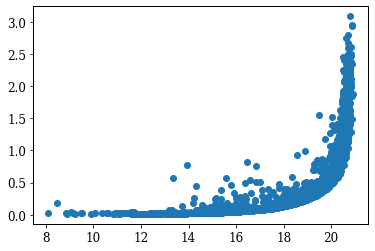

In [17]:
fig, ax = plt.subplots()

ax.scatter(df.phot_g_mean_mag, df.pmra_error)

## Applying better conditions to the variables

In [18]:
condicao = np.abs(0.5*df.pmra) < df.pmra_error
condicao2 = np.abs(0.5*df.pmdec) < df.pmdec_error
condicao3 = np.abs(0.5*df.parallax) < df.parallax_error


df_condicionado = df.drop(df[condicao|condicao2|condicao3].index) #
len(df_condicionado),len(df)

(3919, 7360)

## Dropping uknown values of pmra, pmdec or parallax.

In [19]:
ndf = df_condicionado.dropna(how='any',subset=['pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'parallax', 'parallax_error'])
ndf

,source_id,ra,dec,pmra,pmra_error,pmdec,pmdec_error,bp_rp,phot_g_mean_mag,parallax,parallax_error,radial_velocity,radial_velocity_error,l,b,ruwe,phot_g_n_obs,phot_bp_n_obs,phot_rp_n_obs
1,673129745899199616,114.772565,21.207406,-3.585050,0.077233,-4.081432,0.064215,0.701293,13.157975,1.126842,0.071606,16.952106,3.243045,198.532908,19.647113,6.505512,227,23,24
2,673129745899250560,114.764252,21.202012,6.127572,0.184169,-15.753834,0.157916,2.611496,18.346407,2.887784,0.168608,NaN,NaN,198.535070,19.637893,1.083666,220,24,23
5,673129780258995456,114.787114,21.213089,-1.084624,0.047886,-1.726400,0.039861,0.836451,16.054825,0.614433,0.043731,NaN,NaN,198.532812,19.661819,1.017524,213,20,21
7,673129784554242304,114.788762,21.210233,-2.256829,0.116511,-9.042235,0.096553,1.743275,17.625814,0.991817,0.103900,NaN,NaN,198.536238,19.662152,1.005900,214,22,23
8,673138301474053504,114.452768,21.194469,-7.160788,0.031569,-1.147600,0.024666,0.797316,14.934597,0.573682,0.031311,NaN,NaN,198.424937,19.366571,1.026345,222,24,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7352,865475084542576640,114.388105,21.913480,0.984197,0.175915,-6.799955,0.153870,1.689232,18.163015,0.669466,0.149180,NaN,NaN,197.695341,19.584412,0.959201,194,18,19
7353,865475114611320064,114.408676,21.921099,9.401698,0.745992,-8.928055,0.601997,2.213207,20.004683,1.560563,0.550633,NaN,NaN,197.695522,19.604960,1.043429,220,19,23
7356,865476184052747264,114.520854,21.959722,-8.143218,0.750191,-6.823006,0.584811,2.649399,20.193253,1.812881,0.705757,NaN,NaN,197.699331,19.715892,1.054062,204,14,20
7357,865476184054176896,114.525515,21.958477,-5.314670,0.040932,-7.369153,0.036681,0.906719,15.623176,0.732754,0.036359,NaN,NaN,197.702291,19.719424,1.020532,218,24,22


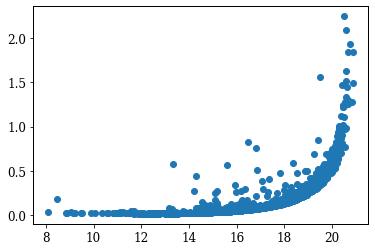

In [20]:
fig, ax = plt.subplots()

ax.scatter(ndf.phot_g_mean_mag, ndf.pmra_error)

In [21]:
#ndf.to_csv('ndf.csv', index=False)

## Determining the background

In [22]:
#.Definicão da função de correção de area
#.(calcula a parte da area de um círculo que esta fora das bordas da imagem)
def area_cor( radata, dedata, ap ):

    cosd = np.cos(dedata*np.pi/180.0)
    rarg = [min(radata),max(radata)]
    derg = [min(dedata),max(dedata)]
    
    b = np.array([(rarg[1]-radata)*cosd, (radata-rarg[0])*cosd, ap])
    c = np.array([ derg[1]-dedata, dedata-derg[0], ap ])
    b = np.min(b,axis=0)  ;  c = np.min(c,axis=0)
    P = 0.5*np.pi*ap**2 - c*np.sqrt(ap**2-c**2) - np.arcsin(c/ap)*ap**2
    Q = 0.5*np.pi*ap**2 - b*np.sqrt(ap**2-b**2) - np.arcsin(b/ap)*ap**2
    O = 0.5*( -c*np.sqrt(ap**2-c**2) - b*np.sqrt(ap**2-b**2) + \
     np.arccos(c/ap)*ap**2 - np.arcsin(b/ap)*ap**2) + c*b
    O = O*(abs(b) < np.sqrt(ap**2-c**2))
    area_cor = -P -Q +O
    return area_cor

0.0004645827936272913


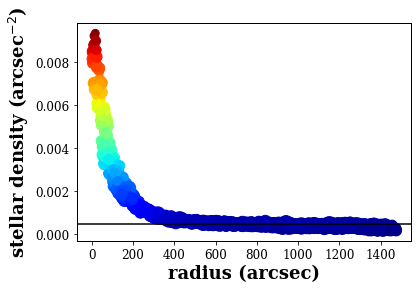

In [23]:
from astropy.coordinates import SkyCoord
from astropy import units
from sklearn.neighbors import NearestNeighbors


catalog = SkyCoord(ra=ndf['ra']*units.degree, dec=ndf['dec']*units.degree, frame='fk5')

nstar = len(ndf)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([ndf['ra'], ndf['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2 + area_cor(ndf.ra, ndf.dec, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(ndf['ra'], weights=den_data)
std_x = np.average((ndf['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(ndf['dec'], weights=den_data)
std_y = np.average((ndf['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value

#.criando figura do RDP

import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()#1,1,figsize=(10,11))
ax.scatter(radii,den_data, s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')


norm_den = den_data/np.max(den_data)
bg_select = (norm_den > 0.04) & (norm_den < 0.15)
med_bg = np.median(den_data[bg_select])
std_bg = 0.5*med_bg

ax.axhline(med_bg, color = 'k')
print(med_bg)



In [24]:
raio_max = np.max(radii)*units.arcsec
raio_max = raio_max.to(units.radian).value
dens = med_bg
dens = dens*(1/units.arcsec*(1/units.arcsec))
dens = dens.to(1/units.sr).value
estrelas = len(df_condicionado) - dens*np.pi*raio_max**2
estrelas

745.8047544941173

## Creating the arrays to perform the 5-D HDBSCAN fit

In [25]:
cincoD = np.dstack((ndf['pmra'],ndf['pmdec'],ndf['ra'],ndf['dec'],ndf['parallax']))[0]
tresD = np.dstack((ndf['pmra'],ndf['pmdec'],ndf['parallax']))[0]

## Performing the HDBSCAN

In [26]:
import hdbscan

In [27]:
from sklearn.preprocessing import RobustScaler

scaled = RobustScaler().fit_transform(cincoD)
scl = RobustScaler().fit_transform(tresD)

Estimated no. of clusters: 1
Estimated no. of noise points: 2472
Estimated no. points clustered: 745


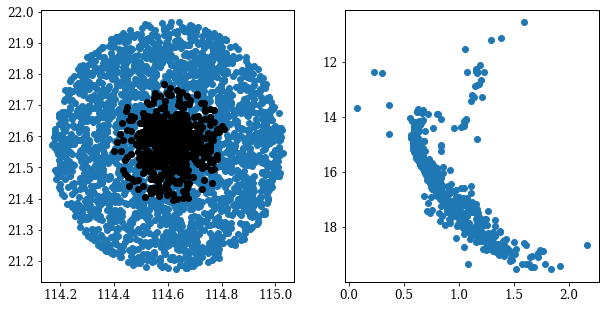

In [28]:
pts_expected = int(estrelas)

clusterer = hdbscan.HDBSCAN(min_cluster_size = pts_expected, min_samples = 400, allow_single_cluster=True, cluster_selection_method = 'eom', metric = 'euclidean').fit(scaled)


labels = clusterer.labels_


ndf = ndf.assign(labels=labels)
ndf = ndf.assign(prob=clusterer.probabilities_)


N_clus=len(set(labels))-(1 if -1 in labels else 0)
print('Estimated no. of clusters: %d' % N_clus)

n_noise = list(clusterer.labels_).count(-1)
print('Estimated no. of noise points: %d' % n_noise)

n_in = list(clusterer.labels_).count(0)
print('Estimated no. points clustered: %d' % n_in)

subset = ndf[ndf.labels == 0]


fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(subset.ra,subset.dec, color = 'k', zorder = 100)
ax[0].scatter(ndf.ra,ndf.dec)

ax[1].scatter(subset['bp_rp'],subset['phot_g_mean_mag'])
ax[1].invert_yaxis()


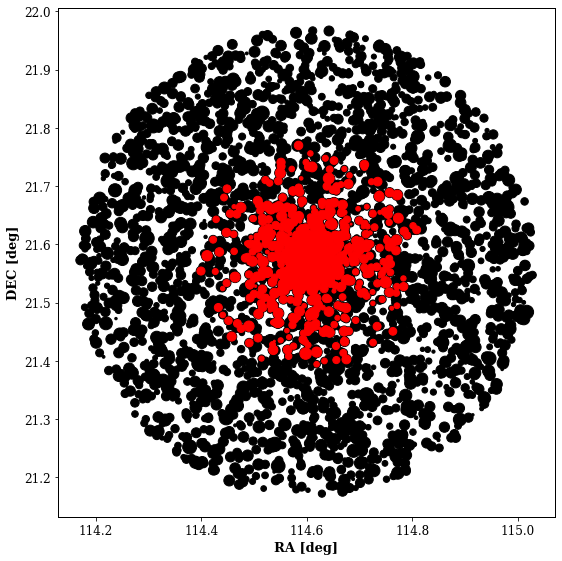

In [29]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(subset.ra,subset.dec,  s=(max(subset['phot_g_mean_mag'])-subset['phot_g_mean_mag'])*20, color = 'red', zorder = 100)
ax.scatter(ndf.ra,ndf.dec,  s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*20, color = 'k')
ax.set_xlabel('RA [deg]', fontweight = 'bold')
ax.set_ylabel('DEC [deg]', fontweight = 'bold')
plt.tight_layout()


## Parameters

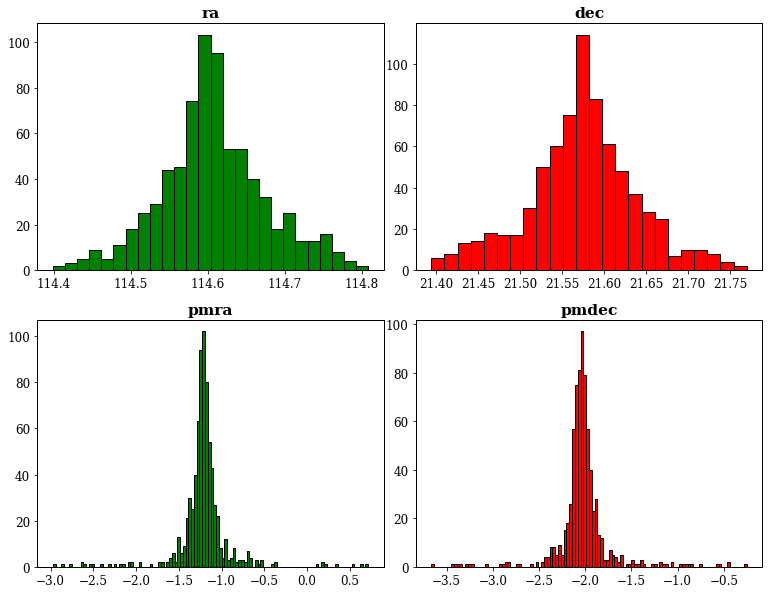

In [30]:
fig = plt.figure(figsize = (13,10))
ax1 = fig.add_subplot(4,4, (1,6))
ax2 = fig.add_subplot(4,4, (9,14))
ax3 = fig.add_subplot(4,4, (3,8))
ax4 = fig.add_subplot(4,4, (11,16))

optimal_bin = np.histogram_bin_edges(subset['ra'], bins = 'fd')
ax1.hist(subset['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['pmra'], bins = 'fd')
ax2.hist(subset['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(subset['dec'], bins = 'fd')
ax3.hist(subset['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(subset['pmdec'], bins = 'fd')
ax4.hist(subset['pmdec'], optimal_bin,  ec = 'k', color = 'red');

ax1.set_title('ra', fontweight = 'bold')
ax2.set_title('pmra', fontweight = 'bold')
ax3.set_title('dec', fontweight = 'bold')
ax4.set_title('pmdec', fontweight = 'bold')

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)


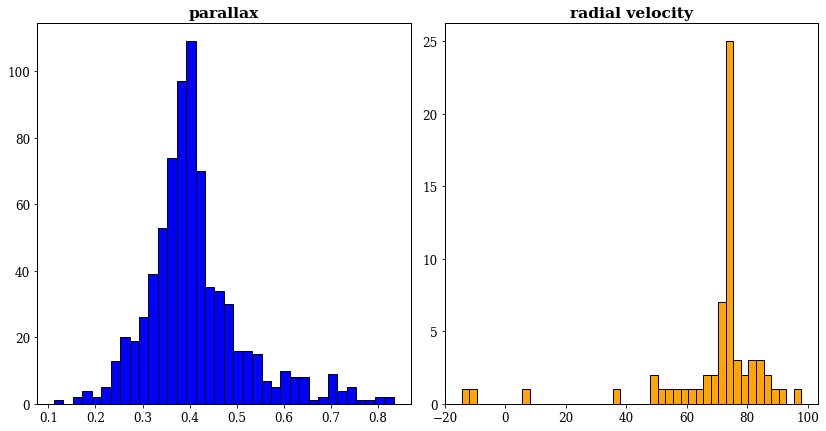

In [31]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(2,4, (1,6))

optimal_bin = np.histogram_bin_edges(subset['parallax'], bins = 'fd')
ax1.hist(subset['parallax'], optimal_bin, ec = 'k',color = 'blue');

ax2 = fig.add_subplot(2,4, (3,8))

ra_vel = subset.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')
ax2.hist(ra_vel.radial_velocity, optimal_bin, ec = 'k',color = 'orange');

ax1.set_title('parallax', fontweight = 'bold')
ax2.set_title('radial velocity', fontweight = 'bold');

## Gaussian fit

In [32]:
def gaussiana(x, amp, mu, sigma):
    return amp*np.exp(-(x-mu)**2/(2*sigma**2))

from lmfit.models import GaussianModel

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 36
    # variables        = 3
    chi-square         = 2350.47500
    reduced chi-square = 71.2265153
    Akaike info crit   = 156.438736
    Bayesian info crit = 161.189293
[[Variables]]
    amplitude:  12.8782086 +/- 0.66756761 (5.18%) (init = 10.10899)
    center:     0.38698033 +/- 0.00341747 (0.88%) (init = 0.3903022)
    sigma:      0.05709619 +/- 0.00341755 (5.99%) (init = 0.03091433)
    fwhm:       0.13445126 +/- 0.00804773 (5.99%) == '2.3548200*sigma'
    height:     89.9825695 +/- 4.66441941 (5.18%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


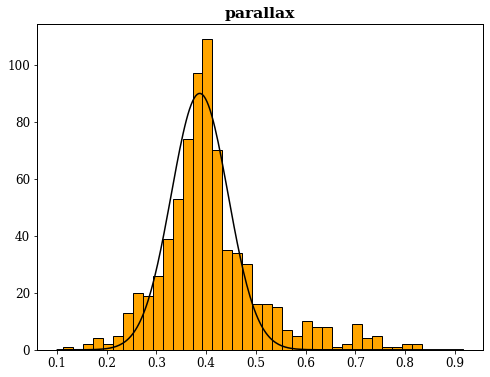

In [33]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['parallax']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'orange');

numero, bins = histograma[0], histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(0.9*bins[0],1.1*bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('parallax', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 26
    # variables        = 3
    chi-square         = 2303.53306
    reduced chi-square = 100.153611
    Akaike info crit   = 122.586673
    Bayesian info crit = 126.360962
[[Variables]]
    amplitude:  11.1165728 +/- 0.69267178 (6.23%) (init = 9.923171)
    center:     114.602587 +/- 0.00395870 (0.00%) (init = 114.612)
    sigma:      0.05502295 +/- 0.00395887 (7.19%) (init = 0.03274974)
    fwhm:       0.12956913 +/- 0.00932242 (7.19%) == '2.3548200*sigma'
    height:     80.6003942 +/- 5.02218354 (6.23%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


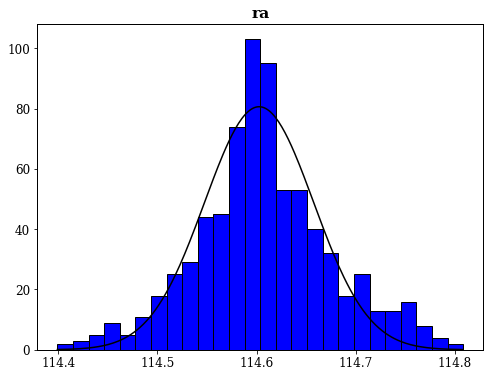

In [34]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['ra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_ra = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('ra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 41
    # data points      = 114
    # variables        = 3
    chi-square         = 1613.98597
    reduced chi-square = 14.5404141
    Akaike info crit   = 308.130063
    Bayesian info crit = 316.338658
[[Variables]]
    amplitude:  19.8374304 +/- 0.47301845 (2.38%) (init = 20.0038)
    center:    -1.21562250 +/- 0.00243776 (0.20%) (init = -1.210417)
    sigma:      0.08853955 +/- 0.00243780 (2.75%) (init = 0.0653719)
    fwhm:       0.20849471 +/- 0.00574059 (2.75%) == '2.3548200*sigma'
    height:     89.3836677 +/- 2.13132769 (2.38%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


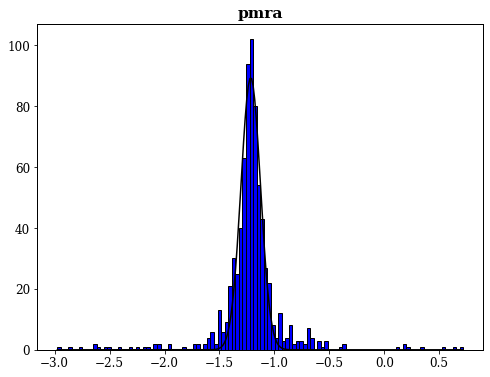

In [35]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmra= [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmra', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 24
    # variables        = 3
    chi-square         = 1957.59475
    reduced chi-square = 93.2187977
    Akaike info crit   = 111.634032
    Bayesian info crit = 115.168194
[[Variables]]
    amplitude:  10.9985921 +/- 0.64186545 (5.84%) (init = 10.97825)
    center:     21.5760714 +/- 0.00342848 (0.02%) (init = 21.57383)
    sigma:      0.05087857 +/- 0.00342858 (6.74%) (init = 0.03267338)
    fwhm:       0.11980987 +/- 0.00807369 (6.74%) == '2.3548200*sigma'
    height:     86.2407059 +/- 5.03290060 (5.84%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


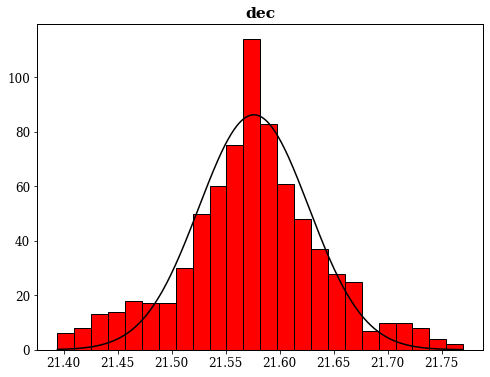

In [36]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['dec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_dec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('dec', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 112
    # variables        = 3
    chi-square         = 1040.38499
    reduced chi-square = 9.54481646
    Akaike info crit   = 255.630891
    Bayesian info crit = 263.786387
[[Variables]]
    amplitude:  18.9552861 +/- 0.36671618 (1.93%) (init = 22.36219)
    center:    -2.04350883 +/- 0.00192573 (0.09%) (init = -2.051407)
    sigma:      0.08620570 +/- 0.00192577 (2.23%) (init = 0.07684601)
    fwhm:       0.20299891 +/- 0.00453484 (2.23%) == '2.3548200*sigma'
    height:     87.7211745 +/- 1.69708404 (1.93%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.577


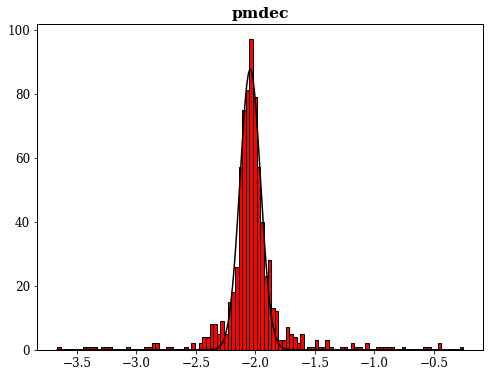

In [37]:
fig, ax = plt.subplots(figsize=(8,6))


data = subset['pmdec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'red');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_pmdec = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('pmdec', fontweight = 'bold')

plt.show()

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 33
    # data points      = 45
    # variables        = 3
    chi-square         = 50.6841197
    reduced chi-square = 1.20676476
    Akaike info crit   = 11.3527568
    Bayesian info crit = 16.7727443
[[Variables]]
    amplitude:  89.5110291 +/- 5.07113833 (5.67%) (init = 1404.491)
    center:     74.5997591 +/- 0.12638258 (0.17%) (init = 74.91633)
    sigma:      1.39304888 +/- 0.08287545 (5.95%) (init = 18.72655)
    fwhm:       3.28037937 +/- 0.19515676 (5.95%) == '2.3548200*sigma'
    height:     25.6342303 +/- 1.24787527 (4.87%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = 0.650
    C(center, sigma)     = 0.483
    C(amplitude, center) = 0.168


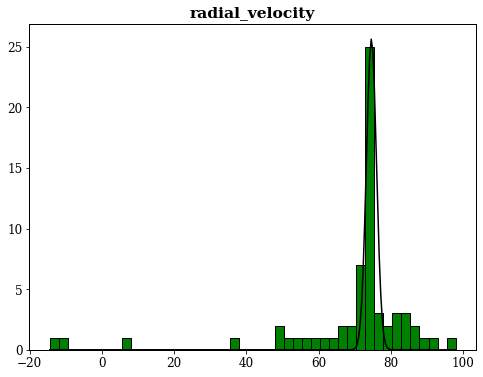

In [38]:
fig, ax = plt.subplots(figsize=(8,6))

ra_vel = subset.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')

data = ra_vel['radial_velocity']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'green');

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]

valores_radial_velocity= [result.params['center'].value, result.params['sigma'].value]


xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('radial_velocity', fontweight = 'bold')

plt.show()

## Sigma Clipping

745
327
269


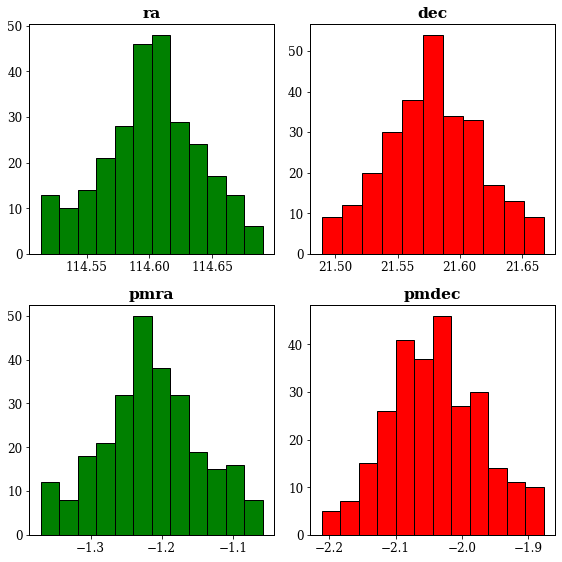

In [39]:
gmodel = GaussianModel()
clip_loop = subset

for i in range(2):
    print(len(clip_loop))
    data = clip_loop['ra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_ra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]
    
    data = clip_loop['dec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_dec = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]


    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


    sigma = 2

    paralaxe_up, paralaxe_down = valores_paralaxe[0] + sigma*valores_paralaxe[1], valores_paralaxe[0] - sigma*valores_paralaxe[1]
    ra_up, ra_down = valores_ra[0] + sigma*valores_ra[1], valores_ra[0] - sigma*valores_ra[1]
    pmra_up, pmra_down = valores_pmra[0] + sigma*valores_pmra[1], valores_pmra[0] - sigma*valores_pmra[1]
    dec_up, dec_down = valores_dec[0] + sigma*valores_dec[1], valores_dec[0] - sigma*valores_dec[1]
    pmdec_up, pmdec_down = valores_pmdec[0] + sigma*valores_pmdec[1], valores_pmdec[0] - sigma*valores_pmdec[1]
    radvel_up, radvel_down = valores_radial_velocity[0] + sigma*valores_radial_velocity[1], valores_radial_velocity[0] - sigma*valores_radial_velocity[1]
    clip_loop = clip_loop.loc[(clip_loop.parallax < paralaxe_up ) & (clip_loop.parallax > paralaxe_down) & (clip_loop.ra>ra_down) & (clip_loop.ra<ra_up) & 
                              (clip_loop.dec>dec_down) & (clip_loop.dec<dec_up) & (clip_loop.pmra>pmra_down) & (clip_loop.pmra<pmra_up) & (clip_loop.pmdec>pmdec_down) 
                              & (clip_loop.pmdec<pmdec_up)  & (clip_loop.radial_velocity.isnull() | (clip_loop.radial_velocity>radvel_down) & (clip_loop.radial_velocity<radvel_up)) ]

    
print(len(clip_loop))

fig = plt.figure(figsize = (8,8))
ax1 = fig.add_subplot(4,4, (1,6))
ax2 = fig.add_subplot(4,4, (9,14))
ax3 = fig.add_subplot(4,4, (3,8))
ax4 = fig.add_subplot(4,4, (11,16))

optimal_bin = np.histogram_bin_edges(clip_loop['ra'], bins = 'fd')
ax1.hist(clip_loop['ra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['pmra'], bins = 'fd')
ax2.hist(clip_loop['pmra'], optimal_bin,  ec = 'k', color = 'green');

optimal_bin = np.histogram_bin_edges(clip_loop['dec'], bins = 'fd')
ax3.hist(clip_loop['dec'], optimal_bin,  ec = 'k', color = 'red');

optimal_bin = np.histogram_bin_edges(clip_loop['pmdec'], bins = 'fd')
ax4.hist(clip_loop['pmdec'], optimal_bin,  ec = 'k', color = 'red');

ax1.set_title('ra', fontweight = 'bold')
ax2.set_title('pmra', fontweight = 'bold')
ax3.set_title('dec', fontweight = 'bold')
ax4.set_title('pmdec', fontweight = 'bold')

plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
plt.tight_layout()


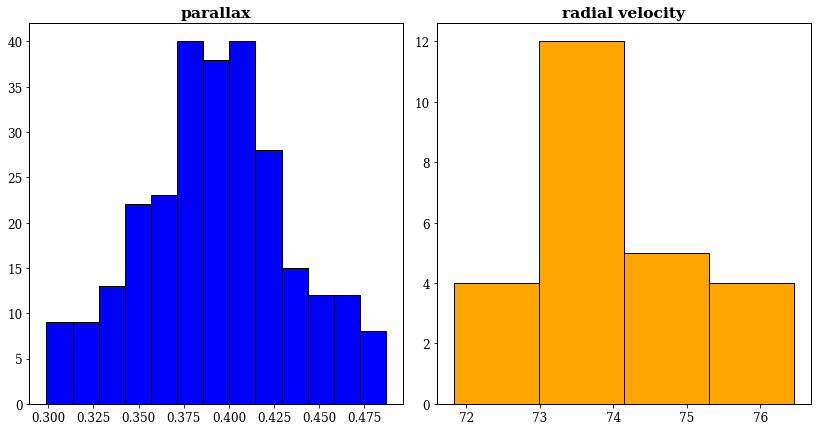

In [40]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(2,4, (1,6))

optimal_bin = np.histogram_bin_edges(clip_loop['parallax'], bins = 'fd')
ax1.hist(clip_loop['parallax'], optimal_bin, ec = 'k',color = 'blue');

ax2 = fig.add_subplot(2,4, (3,8))

ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')
ax2.hist(ra_vel.radial_velocity, optimal_bin, ec = 'k',color = 'orange');

ax1.set_title('parallax', fontweight = 'bold')
ax2.set_title('radial velocity', fontweight = 'bold');

## FINAL RESULTS

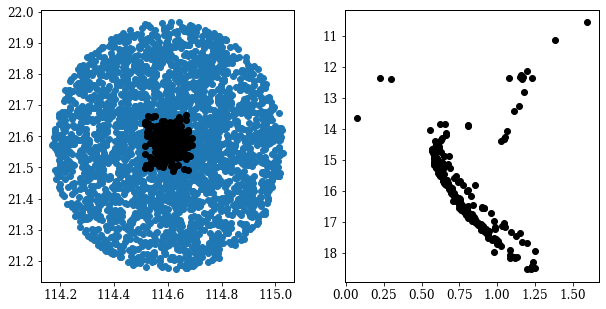

In [41]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].scatter(clip_loop.ra,clip_loop.dec, color = 'k', zorder = 100)
ax[0].scatter(ndf.ra,ndf.dec)


ax[1].scatter(clip_loop['bp_rp'],clip_loop['phot_g_mean_mag'], color = 'k')
ax[1].invert_yaxis()

In [42]:
from astropy.coordinates import Distance

teste =  Distance(parallax=clip_loop['parallax'].to_numpy()*units.mas)

np.min(teste), np.max(teste)

(<Distance 2053.25848814 pc>, <Distance 3344.57600745 pc>)

Text(0, 0.5, 'stellar density (arcsec$^{-2}$)')

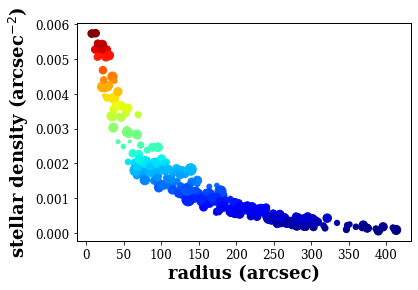

In [43]:
from astropy.coordinates import SkyCoord, Angle
from astropy import units

catalog = SkyCoord(ra=clip_loop['ra']*units.degree, dec=clip_loop['dec']*units.degree, frame='fk5')

nstar = len(clip_loop)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([clip_loop['ra']*np.cos(clip_loop['dec']*np.pi/180.0), clip_loop['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(clip_loop['ra'], weights=den_data)
std_x = np.average((clip_loop['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(clip_loop['dec'], weights=den_data)
std_y = np.average((clip_loop['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value


import matplotlib.cm as cm
cor = cm.get_cmap('jet')

fig, ax = plt.subplots()
ax.scatter(radii,den_data, s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*20, c=den_data/3600**2, cmap = cor, label='data')
ax.set_xlabel('radius (arcsec)', fontsize=18, fontweight='bold')
ax.set_ylabel('stellar density (arcsec$^{-2}$)', fontsize=18, fontweight='bold')



In [44]:
clip_loop.to_csv('membros/final_5d.csv', index=False)

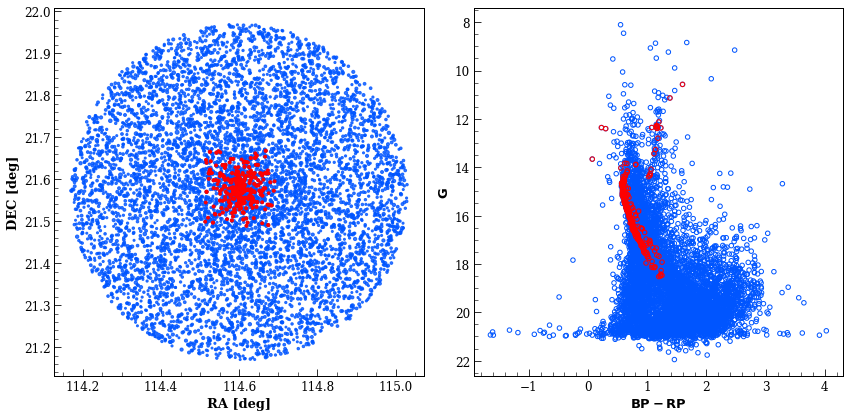

In [45]:
from matplotlib.ticker import AutoMinorLocator

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2,2,(1,3))
ax2 = fig.add_subplot(2,2,(2,4))


ax1.scatter(df['ra'],df['dec'], color = '#0055FF',s=(25-df.phot_g_mean_mag), alpha = 0.8)
ax1.scatter(clip_loop['ra'],clip_loop['dec'], color = 'red', s=(25-clip_loop.phot_g_mean_mag), zorder = 10)
ax1.set_ylabel('DEC [deg]', fontweight = 'bold')
ax1.set_xlabel('RA [deg]', fontweight = 'bold')

ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax1.tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax1.tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax1.tick_params(which = 'minor', axis = 'x', direction='in', length = 4)




ax2.scatter(df['bp_rp'],df['phot_g_mean_mag'], color = 'None', edgecolor = '#0055FF', s = 20)
ax2.scatter(clip_loop['bp_rp'], clip_loop['phot_g_mean_mag'], color = 'None', edgecolor = 'red', s =20)
ax2.set_xlabel('BP - RP', fontweight = 'bold')
ax2.set_ylabel('G', fontweight = 'bold')
ax2.invert_yaxis()
ax2.set_ylabel(r'$\mathbf{G}$')
ax2.set_xlabel(r'$\mathbf{BP - RP}$')
#ax2.grid()

ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax2.tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax2.tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax2.tick_params(which = 'minor', axis = 'x', direction='in', length = 4)

plt.tight_layout()
#plt.savefig('teste.jpg', format = 'jpg', dpi = 300)

In [47]:
cantat_table = pd.read_csv('membros/table-cantat.csv')
#cantat_table.head()

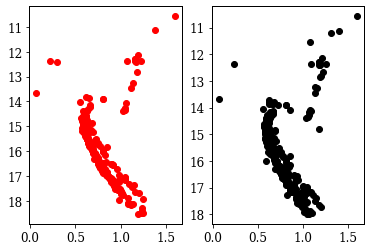

In [48]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,(1,3))
ax2 = fig.add_subplot(2,2,(2,4))

ax1.scatter(clip_loop['bp_rp'],clip_loop['phot_g_mean_mag'], color = 'red')
ax2.scatter(cantat_table['BP-RP'],cantat_table['Gmag'], color = 'k')
ax1.invert_yaxis()
ax2.invert_yaxis()

## PARAMETERS

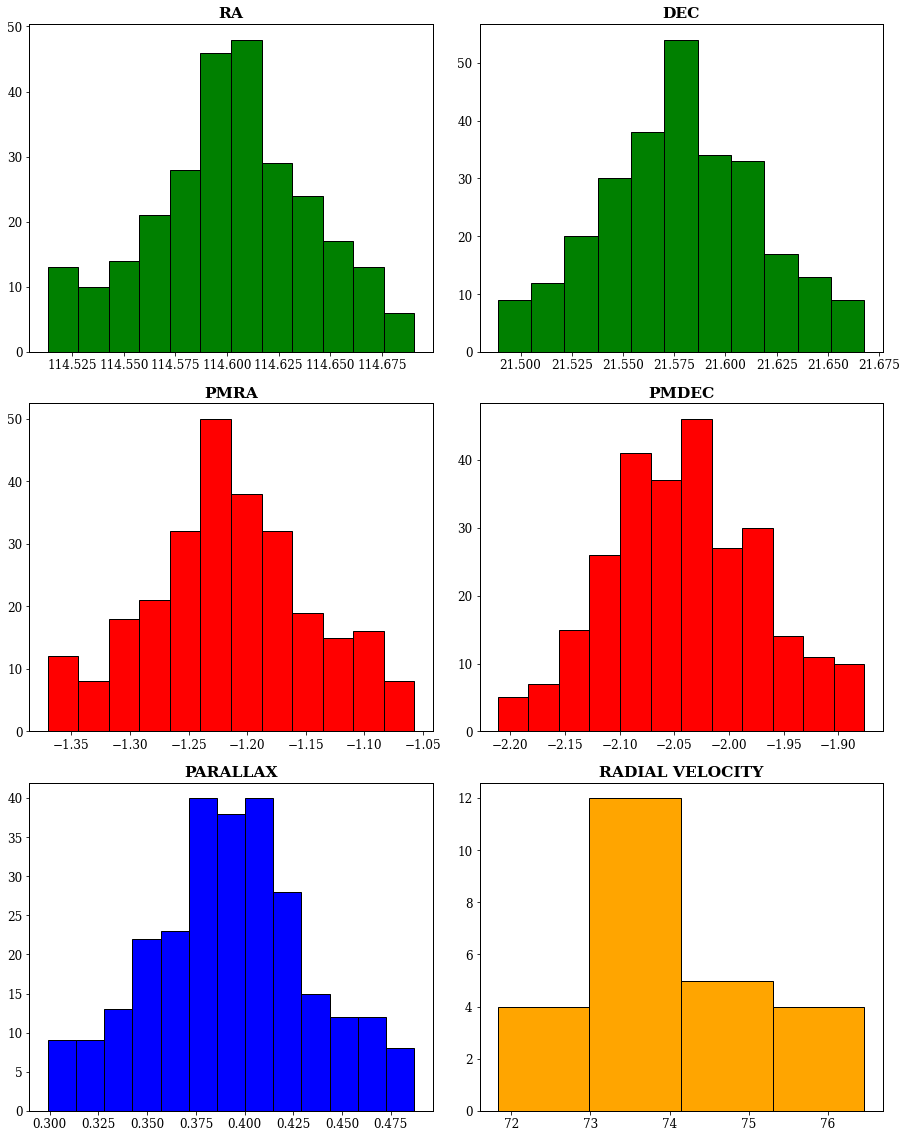

In [49]:
fig, ax = plt.subplots(3,2, figsize=(12.8,16))


optimal_bin = np.histogram_bin_edges(clip_loop['ra'], bins = 'fd')
ax[0,0].hist(clip_loop['ra'], optimal_bin,  ec = 'k', color = 'green');
ax[0,0].set_title('RA', fontweight = 'bold')


optimal_bin = np.histogram_bin_edges(clip_loop['pmra'], bins = 'fd')
ax[1,0].hist(clip_loop['pmra'], optimal_bin,  ec = 'k', color = 'red');
ax[1,0].set_title('PMRA', fontweight = 'bold')

optimal_bin = np.histogram_bin_edges(clip_loop['dec'], bins = 'fd')
ax[0,1].hist(clip_loop['dec'], optimal_bin,  ec = 'k', color = 'green');
ax[0,1].set_title('DEC', fontweight = 'bold')

optimal_bin = np.histogram_bin_edges(clip_loop['pmdec'], bins = 'fd')
ax[1,1].hist(clip_loop['pmdec'], optimal_bin,  ec = 'k', color = 'red');
ax[1,1].set_title('PMDEC', fontweight = 'bold')

optimal_bin = np.histogram_bin_edges(clip_loop['parallax'], bins = 'fd')
ax[2,0].hist(clip_loop['parallax'], optimal_bin, ec = 'k',color = 'blue');
ax[2,0].set_title('PARALLAX', fontweight = 'bold')

ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')
ax[2,1].hist(ra_vel.radial_velocity, optimal_bin, ec = 'k',color = 'orange');
ax[2,1].set_title('RADIAL VELOCITY', fontweight = 'bold')
plt.tight_layout()
#plt.savefig('params_ngc2420.png', format = 'png', dpi = 300)


In [50]:
for i in range(1):
    print(len(clip_loop))
    data = clip_loop['ra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_ra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]
    
    data = clip_loop['dec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_dec = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]


    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


269


In [51]:
valores_ra, valores_dec

([114.60366166543733, 0.04155243908661088],
 [21.577862235816095, 0.043707621890420656])

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 45
    # data points      = 4
    # variables        = 3
    chi-square         = 12.7789102
    reduced chi-square = 12.7789102
    Akaike info crit   = 10.6460072
    Bayesian info crit = 8.80489032
[[Variables]]
    amplitude:  35.6978441 +/- 11.4039077 (31.95%) (init = 18.50058)
    center:     73.5266365 +/- 0.46924061 (0.64%) (init = 73.37327)
    sigma:      1.24119567 +/- 0.43951039 (35.41%) (init = 0.7708575)
    fwhm:       2.92279239 +/- 1.03496785 (35.41%) == '2.3548200*sigma'
    height:     11.4739202 +/- 3.56510079 (31.07%) == '0.3989423*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.579


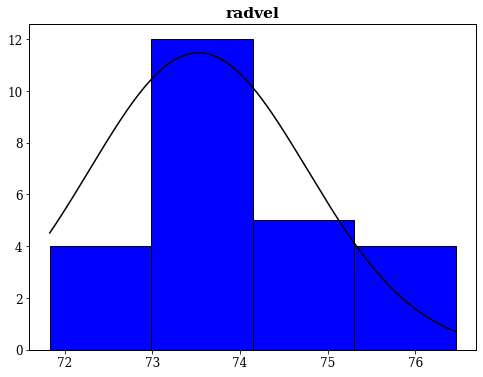

In [52]:
ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')

fig, ax = plt.subplots(figsize=(8,6))


data = ra_vel['radial_velocity']

histograma = ax.hist(data, optimal_bin, ec = 'k',color = 'blue')

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)


print(result.fit_report())



parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]
valores_ra = [result.params['center'].value, result.params['sigma'].value]

xplot = np.linspace(bins[0],bins[-1],128*2)

ax.plot(xplot,gaussiana(xplot,*parametros), color = 'k')

ax.set_title('radvel', fontweight = 'bold')

plt.show()

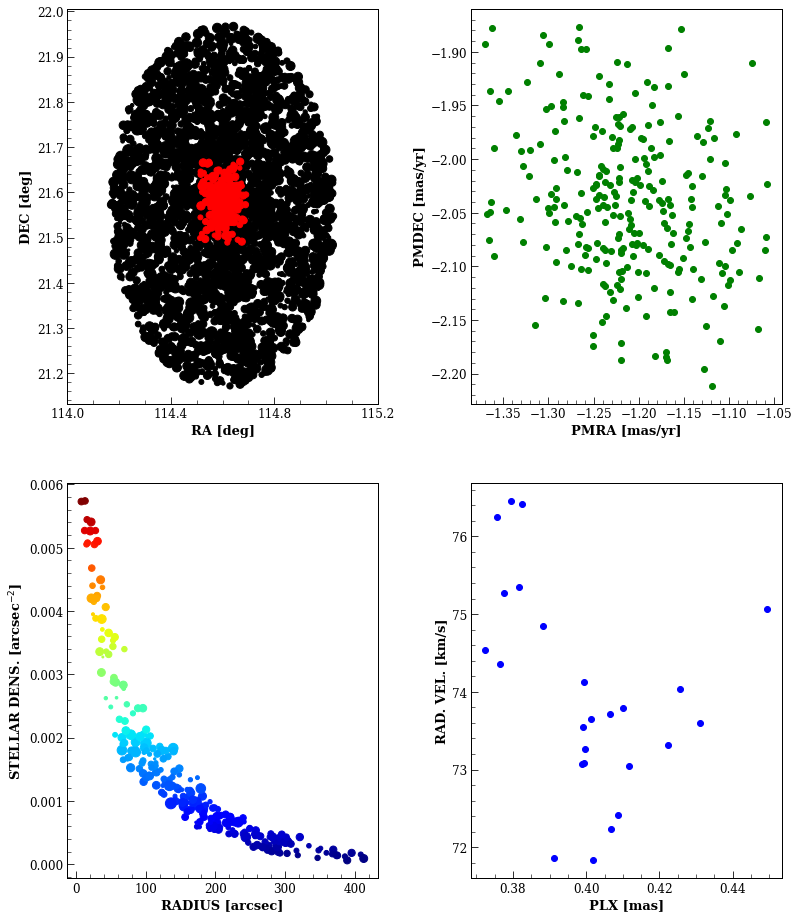

In [53]:
fig, ax = plt.subplots(2,2, figsize=(12.8,16))

ax[0,0].scatter(clip_loop.ra, clip_loop.dec, color = 'red', s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*15, zorder = 100)
ax[0,0].scatter(ndf.ra, ndf.dec, color = 'k', s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*15)
ax[0,0].set_xlabel('RA [deg]', fontweight = 'bold')
ax[0,0].set_ylabel('DEC [deg]', fontweight = 'bold')
#ax[0,0].set_xlim(114.4,114.8)
#ax[0,0].set_ylim(21.4,21.8)


ax[0,1].scatter(clip_loop.pmra, clip_loop.pmdec, color = 'green')
ax[0,1].set_xlabel('PMRA [mas/yr]', fontweight = 'bold')
ax[0,1].set_ylabel('PMDEC [mas/yr]', fontweight = 'bold')


ax[1,1].scatter(ra_vel.parallax, ra_vel.radial_velocity, color = 'blue')
ax[1,1].set_xlabel('PLX [mas]', fontweight = 'bold')
ax[1,1].set_ylabel('RAD. VEL. [km/s]', fontweight = 'bold')


ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0,0].tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax[0,0].tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax[0,0].tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax[0,0].tick_params(which = 'minor', axis = 'x', direction='in', length = 4)

ax[1,1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1,1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1,1].tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax[1,1].tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax[1,1].tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax[1,1].tick_params(which = 'minor', axis = 'x', direction='in', length = 4)

ax[0,1].xaxis.set_minor_locator(AutoMinorLocator())
ax[0,1].yaxis.set_minor_locator(AutoMinorLocator())
ax[0,1].tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax[0,1].tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax[0,1].tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax[0,1].tick_params(which = 'minor', axis = 'x', direction='in', length = 4)



from astropy.coordinates import SkyCoord, Angle
from astropy import units

catalog = SkyCoord(ra=clip_loop['ra']*units.degree, dec=clip_loop['dec']*units.degree, frame='fk5')

nstar = len(clip_loop)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([clip_loop['ra']*np.cos(clip_loop['dec']*np.pi/180.0), clip_loop['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(clip_loop['ra'], weights=den_data)
std_x = np.average((clip_loop['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(clip_loop['dec'], weights=den_data)
std_y = np.average((clip_loop['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value


import matplotlib.cm as cm
cor = cm.get_cmap('jet')


ax[1,0].scatter(radii,den_data, s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*15, c=den_data/3600**2, cmap = cor)
ax[1,0].set_xlabel('RADIUS [arcsec]', fontweight='bold')
ax[1,0].set_ylabel('STELLAR DENS. [arcsec$^{-2}$]', fontweight='bold')


ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax[1,0].tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax[1,0].tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax[1,0].tick_params(which = 'minor', axis = 'x', direction='in', length = 4)


ax[0,0].set_xticks(ax[0,0].get_xticks()[::2])



plt.subplots_adjust(hspace=0.2, wspace = 0.3)
#plt.savefig('ngc2420_3plot.png', format = 'png', dpi = 300)


## Sigma Clippinh Only VPD and plx

In [54]:
gmodel = GaussianModel()
clip_loop = subset


print(len(clip_loop))

j = 4

for i in range(j):
    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]
    
    sigma = 2

    pmra_up, pmra_down = valores_pmra[0] + sigma*valores_pmra[1], valores_pmra[0] - sigma*valores_pmra[1]

    pmdec_up, pmdec_down = valores_pmdec[0] + sigma*valores_pmdec[1], valores_pmdec[0] - sigma*valores_pmdec[1]

    clip_loop = clip_loop.loc[(clip_loop.pmra>pmra_down) & (clip_loop.pmra<pmra_up) & (clip_loop.pmdec>pmdec_down) 
                              & (clip_loop.pmdec<pmdec_up)]

    
print(len(clip_loop))

gmodel = GaussianModel()

for i in range(3):

    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


    sigma = 2

    paralaxe_up, paralaxe_down = valores_paralaxe[0] + sigma*valores_paralaxe[1], valores_paralaxe[0] - sigma*valores_paralaxe[1]
    clip_loop = clip_loop.loc[(clip_loop.parallax < paralaxe_up ) & (clip_loop.parallax > paralaxe_down)]



for i in range(1):
    ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
    data = ra_vel['radial_velocity']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_radial_velocity = [result.params['center'].value, result.params['sigma'].value]
    
    sigma = 3
    
    radvel_up, radvel_down = valores_radial_velocity[0] + sigma*valores_radial_velocity[1], valores_radial_velocity[0] - sigma*valores_radial_velocity[1]
    clip_loop = clip_loop.loc[(clip_loop.radial_velocity.isnull() | (clip_loop.radial_velocity>radvel_down) & (clip_loop.radial_velocity<radvel_up)) ]

ra_vel = clip_loop.dropna(how='any',subset=['radial_velocity'])
print(len(clip_loop))




745
473
374


In [55]:
clip_loop.to_csv('membros/final_semradec.csv', index = False)

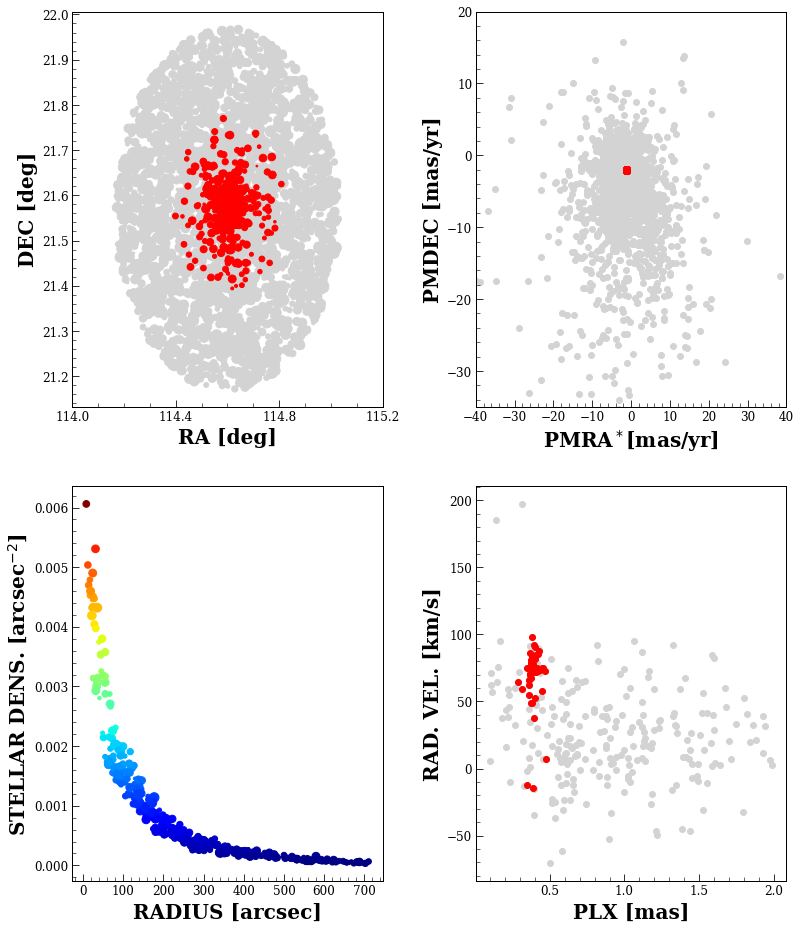

In [61]:
fig, ax = plt.subplots(2,2, figsize=(12.8,16))

ax[0,0].scatter(clip_loop.ra, clip_loop.dec, color = 'red', s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*15, zorder = 100)
ax[0,0].scatter(ndf.ra, ndf.dec, color = 'lightgray', s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*15)
ax[0,0].set_xlabel('RA [deg]', fontweight = 'bold', fontsize = 20)
ax[0,0].set_ylabel('DEC [deg]', fontweight = 'bold', fontsize = 20)
#ax[0,0].set_xlim(114.3,114.9)
#ax[0,0].set_ylim(21.3,21.9)


ax[0,1].scatter(clip_loop.pmra, clip_loop.pmdec, color = 'red', zorder= 100)
ax[0,1].scatter(ndf.pmra, ndf.pmdec, color = 'lightgray')
ax[0,1].set_xlabel('PMRA$^*$[mas/yr]', fontweight = 'bold', fontsize = 20)
ax[0,1].set_ylabel('PMDEC [mas/yr]', fontweight = 'bold',fontsize = 20)
ax[0,1].set_xlim(-40,40)
ax[0,1].set_ylim(-35,20)


ra_vel_ndf = ndf.dropna(how='any',subset=['radial_velocity'])
ra_vel_ndf = ra_vel_ndf.loc[ra_vel_ndf.parallax <2]

ax[1,1].scatter(ra_vel.parallax, ra_vel.radial_velocity, color = 'red', zorder= 100)
ax[1,1].scatter(ra_vel_ndf.parallax, ra_vel_ndf.radial_velocity, color = 'lightgray')
ax[1,1].set_xlabel('PLX [mas]', fontweight = 'bold',fontsize = 20)
ax[1,1].set_ylabel('RAD. VEL. [km/s]', fontweight = 'bold',fontsize = 20)


ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0,0].tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax[0,0].tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax[0,0].tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax[0,0].tick_params(which = 'minor', axis = 'x', direction='in', length = 4)

ax[1,1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1,1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1,1].tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax[1,1].tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax[1,1].tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax[1,1].tick_params(which = 'minor', axis = 'x', direction='in', length = 4)

ax[0,1].xaxis.set_minor_locator(AutoMinorLocator())
ax[0,1].yaxis.set_minor_locator(AutoMinorLocator())
ax[0,1].tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax[0,1].tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax[0,1].tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax[0,1].tick_params(which = 'minor', axis = 'x', direction='in', length = 4)



from astropy.coordinates import SkyCoord, Angle
from astropy import units

catalog = SkyCoord(ra=clip_loop['ra']*units.degree, dec=clip_loop['dec']*units.degree, frame='fk5')

nstar = len(clip_loop)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([clip_loop['ra']*np.cos(clip_loop['dec']*np.pi/180.0), clip_loop['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(clip_loop['ra'], weights=den_data)
std_x = np.average((clip_loop['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(clip_loop['dec'], weights=den_data)
std_y = np.average((clip_loop['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value


import matplotlib.cm as cm
cor = cm.get_cmap('jet')


ax[1,0].scatter(radii,den_data, s=(max(clip_loop['phot_g_mean_mag'])-clip_loop['phot_g_mean_mag'])*15, c=den_data/3600**2, cmap = cor)
ax[1,0].set_xlabel('RADIUS [arcsec]', fontweight='bold', fontsize = 20)
ax[1,0].set_ylabel('STELLAR DENS. [arcsec$^{-2}$]', fontweight='bold',fontsize = 20)


ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax[1,0].tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax[1,0].tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax[1,0].tick_params(which = 'minor', axis = 'x', direction='in', length = 4)


ax[0,0].set_xticks(ax[0,0].get_xticks()[::2])



plt.subplots_adjust(hspace=0.2, wspace = 0.3)


In [57]:
for i in range(1):
    print(len(clip_loop))
    data = clip_loop['ra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_ra = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmra']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmra = [result.params['center'].value, result.params['sigma'].value]
    
    data = clip_loop['dec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_dec = [result.params['center'].value, result.params['sigma'].value]

    data = clip_loop['pmdec']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_pmdec = [result.params['center'].value, result.params['sigma'].value]


    data = clip_loop['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


374


## Clipping redondo

In [58]:
gmodel = GaussianModel()

data = subset['pmra']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
numero, bins = np.histogram(data, optimal_bin)
teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
inicial = gmodel.guess(numero, x = teste)
result = gmodel.fit(numero, inicial, x=teste)
valores_pmra = [result.params['center'].value, result.params['sigma'].value]

gmodel = GaussianModel()

data = subset['pmdec']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
numero, bins = np.histogram(data, optimal_bin)
teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
inicial = gmodel.guess(numero, x = teste)
result = gmodel.fit(numero, inicial, x=teste)
valores_pmdec = [result.params['center'].value, result.params['sigma'].value]

r1sigma = np.sqrt(valores_pmra[1]**2 + valores_pmdec[1]**2)

In [59]:
rs = np.zeros(len(subset))

for i in range(len(subset)):
    star = subset.iloc[i]
    distancia = np.sqrt((valores_pmra[0] - star.pmra)**2 + (valores_pmdec[0]-star.pmdec)**2)
    rs[i] = distancia


In [62]:
teste = subset.assign(rs=rs)
teste_final = teste.loc[rs<=r1sigma]

ra_vel = teste.dropna(how='any',subset=['radial_velocity'])
optimal_bin = np.histogram_bin_edges(ra_vel['radial_velocity'], bins = 'fd')

data = ra_vel['radial_velocity']
optimal_bin = np.histogram_bin_edges(data, bins = 'fd')

histograma = np.histogram(data, optimal_bin);

numero, bins = histograma[0],histograma[1]

centralizar = (bins[1] - bins[0])/2

teste = np.linspace(bins.min(),bins.max(),len(bins) -1)

jpt = np.linspace(np.min(data) + centralizar, np.max(data) - centralizar, len(numero))


gmodel = GaussianModel()

inicial = gmodel.guess(numero, x = teste)

result = gmodel.fit(numero, inicial, x=teste)





parametros = [result.params['height'].value, result.params['center'].value, result.params['sigma'].value]

valores_radial_velocity= [result.params['center'].value, result.params['sigma'].value]



In [63]:
teste = subset.assign(rs=rs)
teste_final = teste.loc[rs<=r1sigma]
print(len(teste_final))
for i in range(1):
    data = teste_final['parallax']
    optimal_bin = np.histogram_bin_edges(data, bins = 'fd')
    numero, bins = np.histogram(data, optimal_bin)
    teste = np.linspace(bins.min(),bins.max(),len(bins) -1)
    inicial = gmodel.guess(numero, x = teste)
    result = gmodel.fit(numero, inicial, x=teste)
    valores_paralaxe = [result.params['center'].value, result.params['sigma'].value]


    sigma = 3

    paralaxe_up, paralaxe_down = valores_paralaxe[0] + sigma*valores_paralaxe[1], valores_paralaxe[0] - sigma*valores_paralaxe[1]
    

    radvel_up, radvel_down = valores_radial_velocity[0] + sigma*valores_radial_velocity[1], valores_radial_velocity[0] - sigma*valores_radial_velocity[1]
    teste_final= teste_final.loc[(teste_final.parallax < paralaxe_up ) & (teste_final.parallax > paralaxe_down)  & (teste_final.radial_velocity.isnull() | (teste_final.radial_velocity>radvel_down) & (teste_final.radial_velocity<radvel_up)) ]
    
print(len(teste_final))


376
333


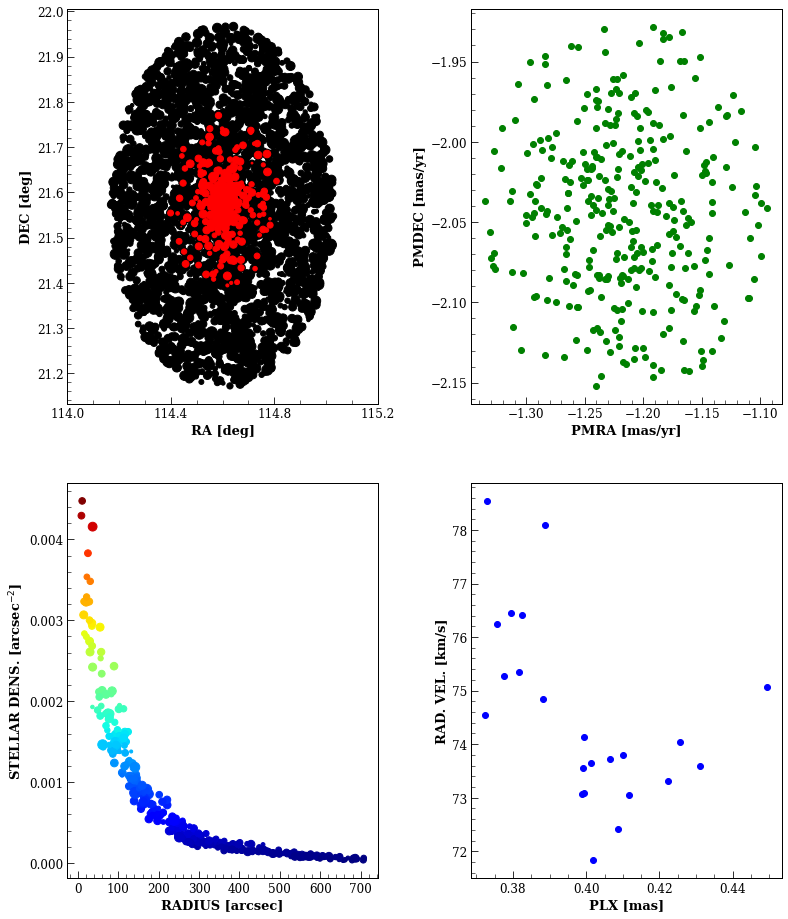

In [64]:
fig, ax = plt.subplots(2,2, figsize=(12.8,16))

ax[0,0].scatter(teste_final.ra, teste_final.dec, color = 'red', s=(max(teste_final['phot_g_mean_mag'])-teste_final['phot_g_mean_mag'])*15, zorder = 100)
ax[0,0].scatter(ndf.ra, ndf.dec, color = 'k', s=(max(ndf['phot_g_mean_mag'])-ndf['phot_g_mean_mag'])*15)
ax[0,0].set_xlabel('RA [deg]', fontweight = 'bold')
ax[0,0].set_ylabel('DEC [deg]', fontweight = 'bold')



ax[0,1].scatter(teste_final.pmra, teste_final.pmdec, color = 'green')
ax[0,1].set_xlabel('PMRA [mas/yr]', fontweight = 'bold')
ax[0,1].set_ylabel('PMDEC [mas/yr]', fontweight = 'bold')

ra_vel = teste_final.dropna(how='any',subset=['radial_velocity'])

ax[1,1].scatter(ra_vel.parallax, ra_vel.radial_velocity, color = 'blue')
ax[1,1].set_xlabel('PLX [mas]', fontweight = 'bold')
ax[1,1].set_ylabel('RAD. VEL. [km/s]', fontweight = 'bold')


ax[0,0].xaxis.set_minor_locator(AutoMinorLocator())
ax[0,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[0,0].tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax[0,0].tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax[0,0].tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax[0,0].tick_params(which = 'minor', axis = 'x', direction='in', length = 4)

ax[1,1].xaxis.set_minor_locator(AutoMinorLocator())
ax[1,1].yaxis.set_minor_locator(AutoMinorLocator())
ax[1,1].tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax[1,1].tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax[1,1].tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax[1,1].tick_params(which = 'minor', axis = 'x', direction='in', length = 4)

ax[0,1].xaxis.set_minor_locator(AutoMinorLocator())
ax[0,1].yaxis.set_minor_locator(AutoMinorLocator())
ax[0,1].tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax[0,1].tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax[0,1].tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax[0,1].tick_params(which = 'minor', axis = 'x', direction='in', length = 4)

from astropy.coordinates import SkyCoord, Angle
from astropy import units

catalog = SkyCoord(ra=teste_final['ra']*units.degree, dec=teste_final['dec']*units.degree, frame='fk5')

nstar = len(clip_loop)

#.Definindo o vizinho apropriado para a abertura

k = np.sqrt(nstar).astype(int)

#.criando a estrutura de vizinhos proximos
coords = np.array([teste_final['ra']*np.cos(teste_final['dec']*np.pi/180.0), teste_final['dec']]).T
nn_struct = NearestNeighbors(n_neighbors=k, algorithm='auto', metric='euclidean')
nn_struct.fit(coords)
distances, index = nn_struct.kneighbors(coords)
             

#.obtendo a distancia do k-esimo vizinho mais proximo
aperture = distances[:,k-1]*units.degree
area = np.pi*(aperture.value)**2# + area_cor(data, data.DEC, aperture.value)
den_data = k/area
den_sigm = np.sqrt(k)/area

den_data /= 3600**2
den_sigm /= 3600**2

med_x = np.average(teste_final['ra'], weights=den_data)
std_x = np.average((teste_final['ra']-med_x)**2, weights=den_data)**0.5

med_y = np.average(teste_final['dec'], weights=den_data)
std_y = np.average((teste_final['dec']-med_y)**2, weights=den_data)**0.5

center = SkyCoord(med_x*units.degree, med_y*units.degree)
radii = center.separation(catalog)
radii = radii.to(units.arcsec).value


import matplotlib.cm as cm
cor = cm.get_cmap('jet')


ax[1,0].scatter(radii,den_data, s=(max(teste_final['phot_g_mean_mag'])-teste_final['phot_g_mean_mag'])*15, c=den_data/3600**2, cmap = cor)
ax[1,0].set_xlabel('RADIUS [arcsec]', fontweight='bold')
ax[1,0].set_ylabel('STELLAR DENS. [arcsec$^{-2}$]', fontweight='bold')


ax[1,0].xaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].tick_params(which = 'major', axis = 'y', direction='in', length = 7)
ax[1,0].tick_params(which = 'minor', axis = 'y', direction='in', length = 4)
ax[1,0].tick_params(which = 'major', axis = 'x', direction='in', length = 7)
ax[1,0].tick_params(which = 'minor', axis = 'x', direction='in', length = 4)


ax[0,0].set_xticks(ax[0,0].get_xticks()[::2])



plt.subplots_adjust(hspace=0.2, wspace = 0.3)
#plt.savefig('ngc2420_3plot.png', format = 'png', dpi = 300)





In [65]:
teste_final.to_csv('membros/raio_vpd.csv', index = False)